<a href="https://colab.research.google.com/github/Sarvagya4/Banking77/blob/main/Banking_77_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers datasets wandb accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.2 MB/s eta 0:00:00


In [ ]:
import os
import math
import pandas as pd
import torch
import torch.nn.functional as F
import warnings
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)
from datasets import Dataset
import wandb


In [ ]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sarvagyatayal (Banking77) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
try:
    train_path = '/content/drive/MyDrive/Banking77_Project/data/train.csv'
    val_path = '/content/drive/MyDrive/Banking77_Project/data/test.csv' # Using test.csv as validation

    print(f"Attempting to load training data from: {train_path}")
    print(f"Attempting to load validation data from: {val_path}")

    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)

    train_dataset = Dataset.from_pandas(train_df)
    val_dataset = Dataset.from_pandas(val_df)

    print("✅ Successfully loaded datasets from Google Drive.")

except FileNotFoundError as e:
    print(f"❌ Error: A required data file was not found.")
    print(f"Details: {e}")
    sys.exit("\nScript terminated. Please check your file paths.")

Attempting to load training data from: /content/drive/MyDrive/Banking77_Project/data/train.csv
Attempting to load validation data from: /content/drive/MyDrive/Banking77_Project/data/test.csv
✅ Successfully loaded datasets from Google Drive.


In [ ]:
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Rename 'intent' to 'label'
try:
    train_dataset = train_dataset.rename_column("intent", "label")
    val_dataset = val_dataset.rename_column("intent", "label")
    print("✅ Renamed 'intent' column to 'label'.")
except ValueError:
    print("Column 'intent' not found or already named 'label'. Skipping rename.")

def preprocess_function(examples):
    return tokenizer(examples['text_cleaned'], truncation=True, max_length=128, padding='max_length')

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)

train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

print("✅ Data preprocessing and formatting complete.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

✅ Renamed 'intent' column to 'label'.


Map:   0%|          | 0/8002 [00:00<?, ? examples/s]

Map:   0%|          | 0/3080 [00:00<?, ? examples/s]

✅ Data preprocessing and formatting complete.


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
class DoRALayer(torch.nn.Module):
    def __init__(self, linear_layer, rank=8, alpha=16):
        super().__init__()
        self.linear_layer = linear_layer
        self.rank = rank
        self.alpha = alpha

        self.register_buffer('pretrained_weight', linear_layer.weight.detach())
        self.m = torch.nn.Parameter(self.pretrained_weight.norm(p=2, dim=0, keepdim=True))
        self.lora_A = torch.nn.Parameter(torch.zeros(linear_layer.in_features, rank))
        self.lora_B = torch.nn.Parameter(torch.zeros(rank, linear_layer.out_features))
        self.scaling = self.alpha / self.rank

        torch.nn.init.kaiming_uniform_(self.lora_A, a=math.sqrt(5))
        torch.nn.init.zeros_(self.lora_B)

    def forward(self, x):
        w_d = F.normalize(self.pretrained_weight, p=2, dim=0)
        lora_update = (self.lora_A @ self.lora_B) * self.scaling
        combined_weight = self.m * w_d + lora_update
        return F.linear(x, combined_weight, self.linear_layer.bias)


In [ ]:


def apply_dora_to_model(model, rank, alpha, target_modules):
    for name, module in model.named_modules():
        if any(target_module in name for target_module in target_modules):
            if isinstance(module, torch.nn.Linear):
                parent_name = '.'.join(name.split('.')[:-1])
                child_name = name.split('.')[-1]
                parent_module = model.get_submodule(parent_name)
                setattr(parent_module, child_name, DoRALayer(module, rank, alpha))

In [ ]:
num_labels = 77  # For Banking77 dataset
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_labels
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# --- TUNED PARAMETER 1: Increased Rank and Alpha ---
dora_rank = 16  # Increased from 8 to 16 for more capacity
dora_alpha = 32 # Increased from 16 to 32 to maintain scaling (2*rank)

apply_dora_to_model(model, dora_rank, dora_alpha, target_modules=["query", "value"])
model.to(device)
print(f"✅ DoRA applied to the model with rank={dora_rank} and alpha={dora_alpha}.")

✅ DoRA applied to the model with rank=16 and alpha=32.


In [ ]:
training_args = TrainingArguments(
    output_dir='./dora_banking77_tuned_results',

    # --- TUNED PARAMETER 2: Increased Epochs ---
    num_train_epochs=5, # Increased from 3 to 5 for more training

    # Batch size can be adjusted based on your new device's GPU memory
    per_device_train_batch_size=16, # Kept at 16, a good default. Try 32 if you have more memory.
    per_device_eval_batch_size=16,

    # --- TUNED PARAMETER 3: Adjusted Learning Rate ---
    learning_rate=3e-4, # Slightly lowered for potentially more stable convergence

    weight_decay=0.01,

    # --- TUNED PARAMETER 4: Added Warmup ---
    warmup_ratio=0.1, # Added for training stability

    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=50,
    report_to="wandb",

    # New run name for clarity
    run_name="dora-banking77-tuned-v1",
)

In [ ]:
!pip install evaluate -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="weighted")
    return {
        "accuracy": acc["accuracy"],
        "f1": f1["f1"]
    }


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/tmp/ipython-input-90289864.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
print("Starting DoRA model training...")
trainer.train()

Starting DoRA model training...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.662800,0.700882,0.804221,0.798553
2,0.536000,0.657139,0.833442,0.828824
3,0.318900,0.535537,0.872727,0.869508
4,0.212700,0.461199,0.896753,0.896379
5,0.066900,0.411090,0.904545,0.904386


TrainOutput(global_step=2505, training_loss=0.33352596545647717, metrics={'train_runtime': 1061.2207, 'train_samples_per_second': 37.702, 'train_steps_per_second': 2.36, 'total_flos': 2652230845908480.0, 'train_loss': 0.33352596545647717, 'epoch': 5.0})

In [ ]:
print("Evaluating the final model...")
eval_metrics = trainer.evaluate()
print("Evaluation Metrics:", eval_metrics)

Evaluating the final model...


Evaluation Metrics: {'eval_loss': 0.4110904932022095, 'eval_accuracy': 0.9045454545454545, 'eval_f1': 0.9043860167055855, 'eval_runtime': 24.2178, 'eval_samples_per_second': 127.179, 'eval_steps_per_second': 7.969, 'epoch': 5.0}


In [ ]:
wandb.log(eval_metrics)


In [ ]:
final_model_path = "/content/drive/MyDrive/banking77_models/dora_final_model"
trainer.save_model(final_model_path)
tokenizer.save_pretrained(final_model_path)
print(f"Final DoRA model saved to {final_model_path}")

Final DoRA model saved to /content/drive/MyDrive/banking77_models/dora_final_model


In [ ]:
wandb.finish()

epoch,▁
eval/accuracy,▁▃▆▇██
eval/f1,▁▃▆▇██
eval/loss,█▄▂▄▃▂▁▁▁
eval/runtime,▁▁▁█▁▁▁▁▆
eval/samples_per_second,███▁████▃
eval/steps_per_second,███▁████▃
eval_accuracy,▁
eval_f1,▁
eval_loss,▁
eval_runtime,▁


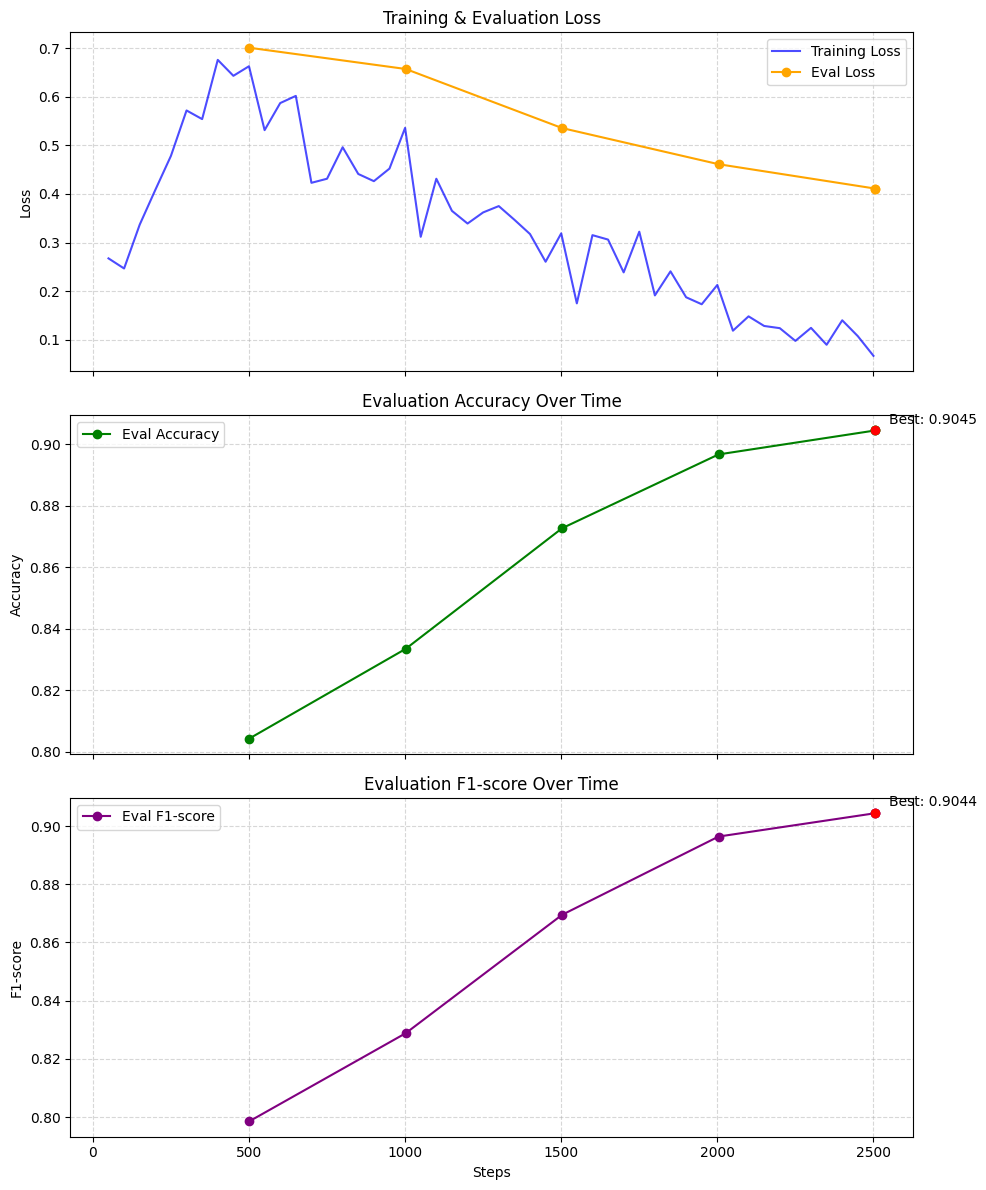

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to DataFrame
df = pd.DataFrame(trainer.state.log_history)

# Separate training and eval logs
train_df = df[df["loss"].notna()]
eval_df = df[df["eval_loss"].notna()]

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)

# --- Loss ---
axes[0].plot(train_df["step"], train_df["loss"], label="Training Loss", color="blue", alpha=0.7)
axes[0].plot(eval_df["step"], eval_df["eval_loss"], label="Eval Loss", color="orange", marker="o")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Evaluation Loss")
axes[0].legend()
axes[0].grid(True, linestyle="--", alpha=0.5)

# --- Accuracy ---
if "eval_accuracy" in eval_df:
    axes[1].plot(eval_df["step"], eval_df["eval_accuracy"], label="Eval Accuracy", color="green", marker="o")
    max_acc_idx = eval_df["eval_accuracy"].idxmax()
    axes[1].scatter(eval_df.loc[max_acc_idx, "step"], eval_df.loc[max_acc_idx, "eval_accuracy"], color="red", zorder=5)
    axes[1].annotate(f"Best: {eval_df.loc[max_acc_idx, 'eval_accuracy']:.4f}",
                     (eval_df.loc[max_acc_idx, "step"], eval_df.loc[max_acc_idx, "eval_accuracy"]),
                     textcoords="offset points", xytext=(10,5))
    axes[1].set_ylabel("Accuracy")
    axes[1].set_title("Evaluation Accuracy Over Time")
    axes[1].legend()
    axes[1].grid(True, linestyle="--", alpha=0.5)

# --- F1-score ---
if "eval_f1" in eval_df:
    axes[2].plot(eval_df["step"], eval_df["eval_f1"], label="Eval F1-score", color="purple", marker="o")
    max_f1_idx = eval_df["eval_f1"].idxmax()
    axes[2].scatter(eval_df.loc[max_f1_idx, "step"], eval_df.loc[max_f1_idx, "eval_f1"], color="red", zorder=5)
    axes[2].annotate(f"Best: {eval_df.loc[max_f1_idx, 'eval_f1']:.4f}",
                     (eval_df.loc[max_f1_idx, "step"], eval_df.loc[max_f1_idx, "eval_f1"]),
                     textcoords="offset points", xytext=(10,5))
    axes[2].set_xlabel("Steps")
    axes[2].set_ylabel("F1-score")
    axes[2].set_title("Evaluation F1-score Over Time")
    axes[2].legend()
    axes[2].grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.show()
